In [ ]:
# 📦 1. Importação de Bibliotecas
!pip install -q imbalanced-learn scikit-optimize seaborn xgboost

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import (classification_report, confusion_matrix,
                            roc_auc_score, average_precision_score,
                            precision_recall_curve, roc_curve, PrecisionRecallDisplay)
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from xgboost import XGBClassifier
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
import joblib
import warnings
warnings.filterwarnings('ignore')

# Configurações de estilo
plt.style.use('ggplot')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 3.8 MB/s eta 0:00:00


In [ ]:
pip install tabulate

## 2. 🔍 Carregamento e Contextualização dos Dados

O conjunto de dados analisado refere-se a transações realizadas com cartões de crédito por clientes europeus, durante dois dias do mês de setembro de 2013. Ao todo, são 284.807 transações, das quais 492 foram identificadas como fraudulentas, o que representa apenas 0,172% do total. Isso caracteriza um forte desbalanceamento entre as classes, com a grande maioria das transações sendo legítimas.

Todas as variáveis de entrada presentes no conjunto são numéricas e foram obtidas por meio da técnica de Análise de Componentes Principais (PCA - Principal Component Analysis). Esse procedimento foi utilizado para anonimizar os dados originais, preservando a privacidade dos clientes e das instituições envolvidas. Por esse motivo, não é possível acessar as variáveis originais nem construir um dicionário de dados interpretável.

As variáveis V1 a V28 representam os componentes principais gerados pela PCA e, portanto, não possuem significados diretos.

As únicas variáveis que não passaram por essa transformação são:

Tempo: representa o tempo (em segundos) decorrido desde a primeira transação registrada no conjunto de dados.

Valor: indica o valor monetário da transação. Essa variável pode ser útil para algoritmos de aprendizado sensível a custos.

Por fim, a variável Classe é a variável alvo do problema. Ela é binária:

Valor 1 indica que a transação foi fraudulenta.

Valor 0 indica uma transação legítima.

In [ ]:
# 📥 2. Carregamento dos Dados
df = pd.read_csv("creditcard.csv")

# Visualização inicial
print(f"Shape do dataset: {df.shape}")
display(df.head())
display(df.describe())
print("")

# Tipos de informações gerais
# Verificação de nulos e duplicatas

print("Shape do dataset:", df.shape)
print("\nTipos de dados e informações gerais:")
print("")
print(df.info())

print("\nRegistros duplicados:", df.duplicated().sum())
df = df.drop_duplicates()
print("Shape após remover duplicatas:", df.shape)

Shape do dataset: (284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,2.239053e-15,1.673327e-15,-1.247012e-15,8.190001e-16,1.207294e-15,4.887456e-15,1.437716e-15,-3.772171e-16,9.564149e-16,1.039917e-15,6.406204e-16,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,1.020713e+00,9.992014e-01,9.952742e-01,9.585956e-01,9.153160e-01,8.762529e-01,8.493371e-01,8.381762e-01,8.140405e-01,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,-4.797473e+00,-1.868371e+01,-5.791881e+00,-1.921433e+01,-4.498945e+00,-1.412985e+01,-2.516280e+01,-9.498746e+00,-7.213527e+00,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,-7.624942e-01,-4.055715e-01,-6.485393e-01,-4.255740e-01,-5.828843e-01,-4.680368e-01,-4.837483e-01,-4.988498e-01,-4.562989e-01,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,-3.275735e-02,1.400326e-01,-1.356806e-02,5.060132e-02,4.807155e-02,6.641332e-02,-6.567575e-02,-3.636312e-03,3.734823e-03,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,7.395934e-01,6.182380e-01,6.625050e-01,4.931498e-01,6.488208e-01,5.232963e-01,3.996750e-01,5.008067e-01,4.589494e-01,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,1.201891e+01,7.848392e+00,7.126883e+00,1.052677e+01,8.877742e+00,1.731511e+01,9.253526e+00,5.041069e+00,5.591971e+00,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000



Shape do dataset: (284807, 31)

Tipos de dados e informações gerais:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 

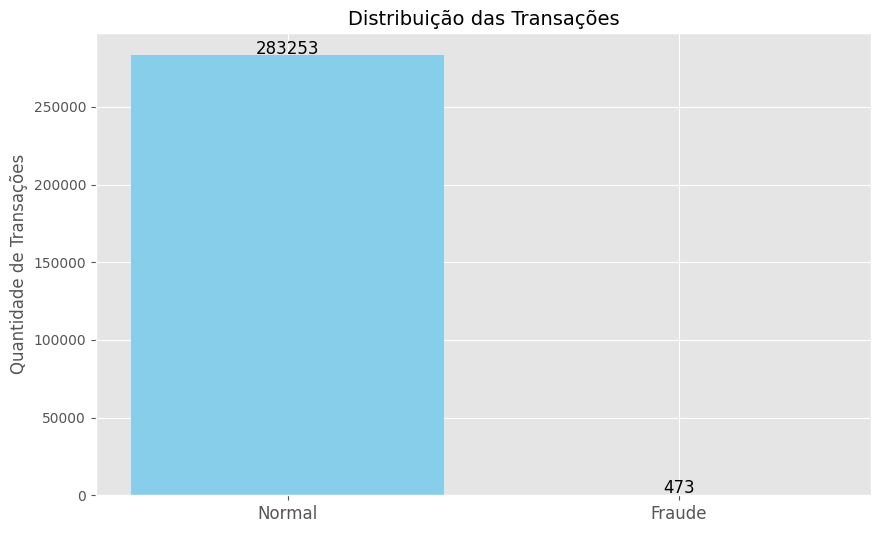


Proporção de fraudes: 0.1667%


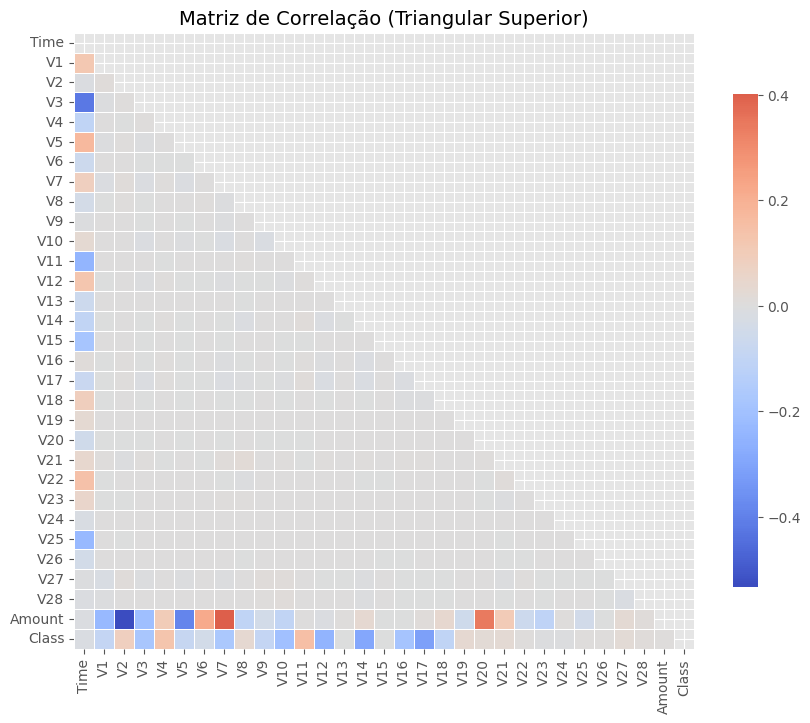

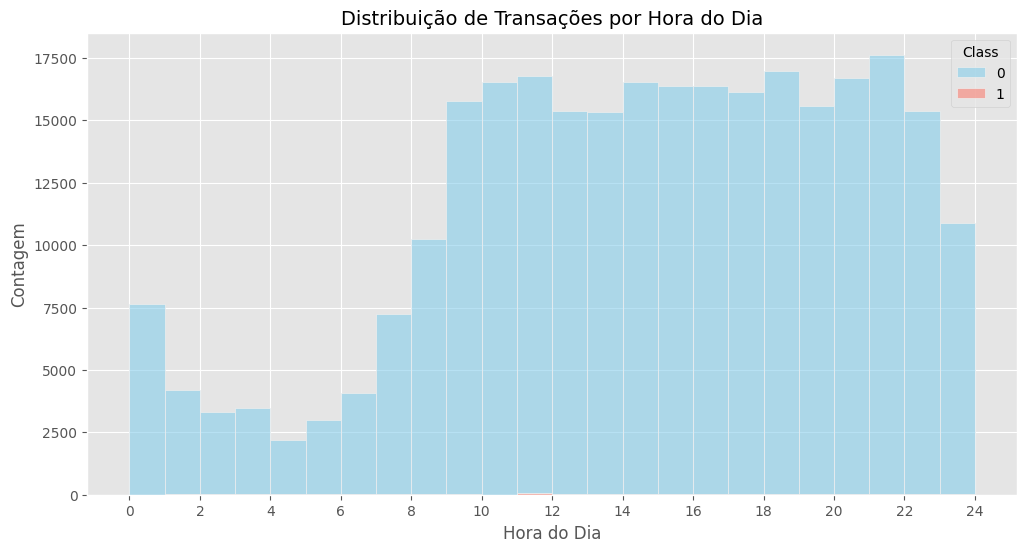

In [ ]:
# 🔍 3. Análise Exploratória Detalhada

# 3.1 Distribuição das classes
plt.figure(figsize=(10, 6))
classes = df['Class'].value_counts()
plt.bar(['Normal', 'Fraude'], classes, color=['skyblue', 'salmon'])
plt.title('Distribuição das Transações', fontsize=14)
plt.ylabel('Quantidade de Transações', fontsize=12)
plt.xticks(fontsize=12)
for i, v in enumerate(classes):
    plt.text(i, v + 1000, str(v), ha='center', fontsize=12)
plt.show()

print(f"\nProporção de fraudes: {classes[1]/classes.sum()*100:.4f}%")


# 3.2 Matriz de correlação
corr = df.corr()
plt.figure(figsize=(10, 8))
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, cmap='coolwarm', center=0,
           annot=False, fmt=".2f", linewidths=.5,
           cbar_kws={"shrink": .8})
plt.title('Matriz de Correlação (Triangular Superior)', fontsize=14)
plt.show()
print('')
# 3.3 Análise temporal
df['Hour'] = df['Time'] % (24*60*60) / (60*60)
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='Hour', hue='Class', bins=24,
             palette={0:'skyblue', 1:'salmon'},
             alpha=0.6, multiple='stack')
plt.title('Distribuição de Transações por Hora do Dia', fontsize=14)
plt.xlabel('Hora do Dia', fontsize=12)
plt.ylabel('Contagem', fontsize=12)
plt.xticks(range(0, 25, 2))
plt.show()

## 💳 Sobre a variável Amount

A variável Amount representa o valor monetário de cada transação realizada com cartão de crédito. Essa coluna é uma das poucas variáveis do conjunto de dados que não passou pela transformação PCA, e por isso pode apresentar uma escala muito diferente das demais variáveis.

Para melhorar o desempenho dos modelos de Machine Learning e garantir uma melhor distribuição e escala dos dados, aplicamos duas transformações nesta variável:

🔢 Amount_Log: Aplicação do logaritmo natural com ajuste (log1p) para reduzir a assimetria da distribuição e lidar melhor com variações extremas de valor.

📏 Amount_Scaled: Aplicação do StandardScaler, que padroniza os valores para média 0 e desvio padrão 1. Essa etapa é fundamental para algoritmos que são sensíveis à escala dos dados, como SVM, KNN e regressão logística.

Essas novas features auxiliam na normalização e padronização do valor das transações, contribuindo para um melhor desempenho dos modelos de detecção de fraude.

In [ ]:
# 🧼 4. Pré-processamento e Engenharia de Features

# 4.1 Criação de novas features
df['Amount_Log'] = np.log1p(df['Amount'])
df['Amount_Scaled'] = StandardScaler().fit_transform(df['Amount'].values.reshape(-1, 1))

# 4.2 Divisão em treino e teste
X = df.drop(['Class', 'Time'], axis=1)
y = df['Class']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Shape do treino: {X_train.shape}")
print(f"Shape do teste: {X_test.shape}")

Shape do treino: (226980, 32)
Shape do teste: (56746, 32)


# 🔄 5. Balanceamento de Dados e Modelagem


In [ ]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

# Verificando a distribuição original
print("Distribuição original das classes:")
print(y_train.value_counts())

# Definindo a estratégia de balanceamento
# SMOTE para oversampling da classe minoritária
# Undersampling para reduzir a classe majoritária
smote = SMOTE(random_state=42, sampling_strategy=0.5)  # Aumenta a classe minoritária para 50% da majoritária
under = RandomUnderSampler(random_state=42, sampling_strategy=0.8)  # Reduz a classe majoritária para 80% da minoritária

# Criando o pipeline
pipeline = Pipeline([
    ('smote', smote),
    ('under', under)
])

# Aplicando o balanceamento combinado
X_resampled, y_resampled = pipeline.fit_resample(X_train, y_train)

# Verificando o resultado
print("\nDistribuição após SMOTE + Undersampling:")
print(pd.Series(y_resampled).value_counts())

# Visualização opcional
def plot_balanceamento(X, y, title):
    if X.shape[1] == 2:
        plt.figure(figsize=(10, 6))
        plt.scatter(X[y == 0][:, 0], X[y == 0][:, 1], label="Classe 0", alpha=0.5)
        plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], label="Classe 1", alpha=0.5)
    else:
        from sklearn.decomposition import PCA
        pca = PCA(n_components=2)
        X = pca.fit_transform(X)
        plt.figure(figsize=(10, 6))
        plt.scatter(X[y == 0][:, 0], X[y == 0][:, 1], label="Classe 0", alpha=0.5)
        plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], label="Classe 1", alpha=0.5)

    plt.title(title)
    plt.legend()
    plt.show()

# Salvando os dados balanceados (opcional)
if input("Deseja salvar os dados balanceados? (s/n): ").lower() == 's':
    resampled_df = pd.DataFrame(X_resampled, columns=X_train.columns)
    resampled_df['target'] = y_resampled
    resampled_df.to_csv('dados_balanceados_smote_undersample.csv', index=False)
    print("Dados balanceados salvos em 'dados_balanceados_smote_undersample.csv'")

# Exemplo de como ajustar as proporções:
# sampling_strategy no SMOTE: proporção da classe minoritária em relação à majoritária
# sampling_strategy no Undersampler: proporção da classe majoritária em relação à minoritária
# Exemplo alternativo com proporções diferentes:
# smote = SMOTE(sampling_strategy=0.8)  # Classe minoritária chega a 80% da majoritária
# under = RandomUnderSampler(sampling_strategy=1)  # Classes ficam equilibradas 1:1

Distribuição original das classes:
Class
0    226602
1       378
Name: count, dtype: int64

Distribuição após SMOTE + Undersampling:
Class
0    141626
1    113301
Name: count, dtype: int64
Deseja salvar os dados balanceados? (s/n): s
Dados balanceados salvos em 'dados_balanceados_smote_undersample.csv'


6. Avaliação do Desempenho dos Modelos Preditivos

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (classification_report, confusion_matrix,
                            roc_auc_score, accuracy_score, f1_score)
from sklearn.preprocessing import StandardScaler
import time
from tabulate import tabulate
from IPython.display import display, HTML
import warnings
from sklearn.exceptions import ConvergenceWarning

# Configurações
warnings.filterwarnings('ignore', category=ConvergenceWarning)
warnings.filterwarnings('ignore', category=UserWarning)

# === 1. Carregar dados ===
def load_data(filepath):
    df = pd.read_csv(filepath)
    # Otimização de tipos
    for col in df.columns:
        if df[col].dtype == 'float64':
            df[col] = df[col].astype('float32')
        elif df[col].dtype == 'int64':
            df[col] = df[col].astype('int32')
    return df

df_balanced = load_data('dados_balanceados_smote_undersample.csv')

# === 2. Separar features e target ===
X = df_balanced.drop("target", axis=1)
y = df_balanced["target"].astype('int8')

# === 3. Dividir dados ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

# === 4. Padronizar dados ===
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train).astype('float32')
X_test_scaled = scaler.transform(X_test).astype('float32')

# === 5. Modelos otimizados ===
modelos = {
    "Random Forest": RandomForestClassifier(
        n_estimators=100, random_state=42, n_jobs=-1, max_depth=10
    ),
    "Logistic Regression": LogisticRegression(
        max_iter=500, random_state=42, solver='liblinear', n_jobs=-1
    ),
    "Decision Tree": DecisionTreeClassifier(
        random_state=42, max_depth=5
    )
}

# === 6. Função de avaliação com visualização melhorada ===
def evaluate_and_display(model, name, X_train, y_train, X_test, y_test):
    start_time = time.time()

    # Validação cruzada
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, n_jobs=-1, scoring='roc_auc')

    # Treino
    model.fit(X_train, y_train)
    train_time = time.time() - start_time

    # Predições
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    # Métricas
    metrics = {
        'Modelo': name,
        'AUC (Validação Cruzada)': f"{np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}",
        'AUC (Teste)': f"{roc_auc_score(y_test, y_proba):.4f}",
        'Acurácia': f"{accuracy_score(y_test, y_pred):.4f}",
        'F1-Score': f"{f1_score(y_test, y_pred):.4f}",
        'Tempo (s)': f"{train_time:.2f}"
    }

    # Matriz de confusão
    cm = confusion_matrix(y_test, y_pred)
    cm_df = pd.DataFrame(cm, index=['Real 0', 'Real 1'],
                         columns=['Predito 0', 'Predito 1'])

    # Relatório de classificação
    clf_report = classification_report(y_test, y_pred, output_dict=True)
    clf_df = pd.DataFrame(clf_report).transpose()

    return metrics, cm_df, clf_df

# === 7. Avaliar modelos e exibir resultados ===
all_metrics = []
for name, model in modelos.items():
    metrics, cm, report = evaluate_and_display(
        model, name, X_train_scaled, y_train, X_test_scaled, y_test)
    all_metrics.append(metrics)

    # Exibir resultados para cada modelo
    display(HTML(f"<h2 style='color:#1f77b4'>📊 {name}</h2>"))

    # Tabela de métricas
    display(HTML(tabulate(pd.DataFrame([metrics]),
                 headers='keys',
                 tablefmt='html',
                 showindex=False)))

    # Matriz de confusão
    display(HTML("<h4>🔍 Matriz de Confusão</h4>"))
    display(HTML(cm.to_html(classes='table table-striped')))

    # Relatório de classificação
    display(HTML("<h4>📝 Relatório de Classificação</h4>"))
    display(HTML(report.to_html(classes='table table-striped')))

    display(HTML("<hr style='border:1px solid #f0f0f0'>"))

# Tabela comparativa final
final_results = pd.DataFrame(all_metrics)
display(HTML("<h2 style='text-align:center'>🏆 Resultados Comparativos</h2>"))
display(HTML(final_results.to_html(classes='table table-hover',
                                 index=False,
                                 float_format='{:.4f}'.format)))

# Opcional: Salvar resultados em HTML
# final_results.to_html('resultados_modelos.html', index=False)

Modelo,AUC (Validação Cruzada),AUC (Teste),Acurácia,F1-Score,Tempo (s)
Random Forest,0.9998 ± 0.0000,0.9998,0.9884,0.9868,646.72


,Predito 0,Predito 1
Real 0,28299,27
Real 1,564,22096


,precision,recall,f1-score,support
0,0.980459,0.999047,0.989666,28326.000000
1,0.998780,0.975110,0.986803,22660.000000
accuracy,0.988409,0.988409,0.988409,0.988409
macro avg,0.989619,0.987079,0.988234,50986.000000
weighted avg,0.988602,0.988409,0.988394,50986.000000


Modelo,AUC (Validação Cruzada),AUC (Teste),Acurácia,F1-Score,Tempo (s)
Logistic Regression,0.9940 ± 0.0004,0.9941,0.9656,0.9604,32.01


,Predito 0,Predito 1
Real 0,27948,378
Real 1,1378,21282


,precision,recall,f1-score,support
0,0.953011,0.986655,0.969541,28326.000000
1,0.982548,0.939188,0.960379,22660.000000
accuracy,0.965559,0.965559,0.965559,0.965559
macro avg,0.967780,0.962922,0.964960,50986.000000
weighted avg,0.966138,0.965559,0.965469,50986.000000


Modelo,AUC (Validação Cruzada),AUC (Teste),Acurácia,F1-Score,Tempo (s)
Decision Tree,0.9912 ± 0.0005,0.9916,0.9667,0.9622,34.54


,Predito 0,Predito 1
Real 0,27698,628
Real 1,1070,21590


,precision,recall,f1-score,support
0,0.962806,0.977830,0.970260,28326.000000
1,0.971735,0.952780,0.962164,22660.000000
accuracy,0.966697,0.966697,0.966697,0.966697
macro avg,0.967270,0.965305,0.966212,50986.000000
weighted avg,0.966774,0.966697,0.966662,50986.000000


Modelo,AUC (Validação Cruzada),AUC (Teste),Acurácia,F1-Score,Tempo (s)
Random Forest,0.9998 ± 0.0000,0.9998,0.9884,0.9868,646.72
Logistic Regression,0.9940 ± 0.0004,0.9941,0.9656,0.9604,32.01
Decision Tree,0.9912 ± 0.0005,0.9916,0.9667,0.9622,34.54


## REGRESSÃO LOGISTICA

,Valor
Acurácia,0.9653
Precisão,0.9822
Recall,0.9388
F1-Score,0.9600
AUC-ROC,0.9940
AP Score,0.9936


,Valor
Acurácia,0.9659
Precisão,0.9827
Recall,0.9398
F1-Score,0.9608
AUC-ROC,0.9945
AP Score,0.9942


,Métrica,Treino,Teste,Diferença
0,Acurácia,0.9653,0.9659,0.0006
1,Precisão,0.9822,0.9827,0.0005
2,Recall,0.9388,0.9398,0.0010
3,F1-Score,0.9600,0.9608,0.0007
4,AUC-ROC,0.9940,0.9945,0.0005


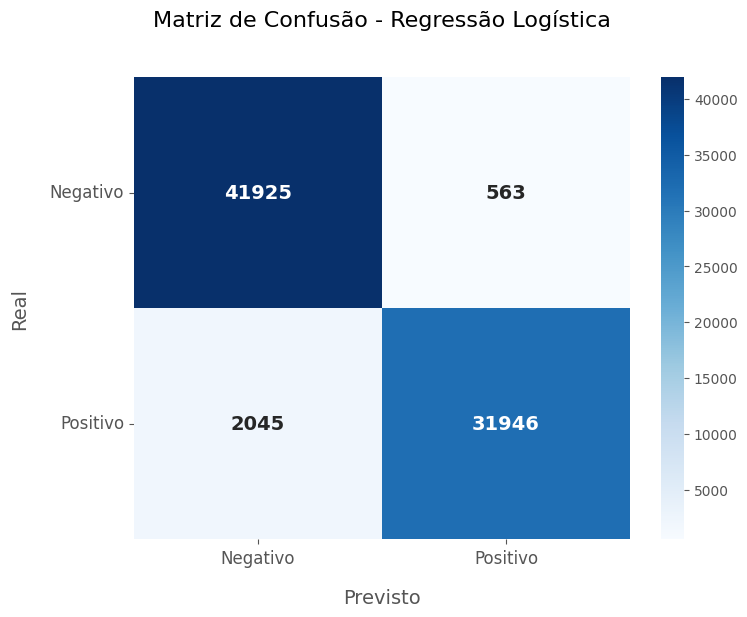

,Fold,Acurácia,Desempenho
0,1,0.9646,Ótimo
1,2,0.9662,Ótimo
2,3,0.9642,Ótimo
3,4,0.9667,Ótimo
4,5,0.9650,Ótimo


In [ ]:
from sklearn.model_selection import train_test_split, learning_curve, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (classification_report, confusion_matrix,
                           roc_auc_score, accuracy_score, precision_score,
                           recall_score, f1_score, precision_recall_curve,
                           average_precision_score)
from tabulate import tabulate
from IPython.display import display, HTML

# --- 1. Carregar e preparar dados ---
dados_balanceados = pd.read_csv('dados_balanceados_smote_undersample.csv')
X = dados_balanceados.drop('target', axis=1)
y = dados_balanceados['target']

# Dividir dados
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# --- 2. Treinar modelo ---
modelo_lr = LogisticRegression(max_iter=1000, random_state=42, solver='liblinear')
modelo_lr.fit(X_train, y_train)

# --- 3. Gerar previsões ---
y_pred = modelo_lr.predict(X_test)
y_proba = modelo_lr.predict_proba(X_test)[:, 1]
y_train_pred = modelo_lr.predict(X_train)
y_train_proba = modelo_lr.predict_proba(X_train)[:, 1]

# --- 4. Relatório de Métricas Formatado ---
def styled_metric_report(y_true, y_pred, y_proba, title):
    metrics = {
        'Acurácia': accuracy_score(y_true, y_pred),
        'Precisão': precision_score(y_true, y_pred),
        'Recall': recall_score(y_true, y_pred),
        'F1-Score': f1_score(y_true, y_pred),
        'AUC-ROC': roc_auc_score(y_true, y_proba),
        'AP Score': average_precision_score(y_true, y_proba)
    }
    df = pd.DataFrame.from_dict(metrics, orient='index', columns=['Valor'])
    df['Valor'] = df['Valor'].apply(lambda x: f"{x:.4f}")

    # Estilo da tabela
    table_style = [
        {'selector': 'th',
         'props': [('background-color', '#4472C4'),
                  ('color', 'white'),
                  ('font-weight', 'bold'),
                  ('text-align', 'center')]},
        {'selector': 'td',
         'props': [('text-align', 'center')]},
        {'selector': '',
         'props': [('border', '1px solid #ddd'),
                   ('border-collapse', 'collapse'),
                   ('width', '50%'),
                   ('margin', '0 auto')]}
    ]

    display(HTML(f"<h3 style='color:#2E75B6; text-align:center'>{title}</h3>"))
    display(df.style.set_table_styles(table_style)
                  .set_properties(**{'background-color': '#F2F2F2',
                                    'border': '1px solid #ddd'}))

# Relatórios para treino e teste
styled_metric_report(y_train, y_train_pred, y_train_proba, "MÉTRICAS DE TREINO")
styled_metric_report(y_test, y_pred, y_proba, "MÉTRICAS DE TESTE")

# --- 5. Tabela Comparativa de Overfitting ---
metrics_train = {
    'Acurácia': accuracy_score(y_train, y_train_pred),
    'Precisão': precision_score(y_train, y_train_pred),
    'Recall': recall_score(y_train, y_train_pred),
    'F1-Score': f1_score(y_train, y_train_pred),
    'AUC-ROC': roc_auc_score(y_train, y_train_proba)
}

metrics_test = {
    'Acurácia': accuracy_score(y_test, y_pred),
    'Precisão': precision_score(y_test, y_pred),
    'Recall': recall_score(y_test, y_pred),
    'F1-Score': f1_score(y_test, y_pred),
    'AUC-ROC': roc_auc_score(y_test, y_proba)
}

comparison_df = pd.DataFrame({
    'Métrica': list(metrics_train.keys()),
    'Treino': [f"{v:.4f}" for v in metrics_train.values()],
    'Teste': [f"{v:.4f}" for v in metrics_test.values()],
    'Diferença': [f"{abs(a-b):.4f}" for a, b in zip(metrics_train.values(), metrics_test.values())]
})

# Adicionar estilo condicional
def highlight_overfit(row):
    diff = float(row['Diferença'])
    color = '#FFC7CE' if diff > 0.1 else ('#FFEB9C' if diff > 0.05 else '#C6EFCE')
    return ['background-color: ' + color for _ in row]

display(HTML("<h3 style='color:#2E75B6; text-align:center'>COMPARAÇÃO TREINO-TESTE (OVERFITTING)</h3>"))
display(comparison_df.style.apply(highlight_overfit, axis=1)
                        .set_table_styles([
                            {'selector': 'th',
                             'props': [('background-color', '#4472C4'),
                                      ('color', 'white'),
                                      ('font-weight', 'bold')]},
                            {'selector': 'td',
                             'props': [('text-align', 'center')]}
                        ]))


# --- 6. Visualização da Matriz de Confusão Aprimorada ---
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred),
            annot=True, fmt='d', cmap='Blues',
            annot_kws={"size": 14, "weight": "bold"},
            xticklabels=['Negativo', 'Positivo'],
            yticklabels=['Negativo', 'Positivo'])
plt.title('Matriz de Confusão - Regressão Logística\n', fontsize=16, pad=20)
plt.xlabel('Previsto', fontsize=14, labelpad=15)
plt.ylabel('Real', fontsize=14, labelpad=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12, rotation=0)
plt.show()

# --- 7. Gráfico de Coeficientes com Estilo ---
if len(X.columns) <= 20:
    coef_df = pd.DataFrame({'Feature': X.columns, 'Coeficiente': modelo_lr.coef_[0]})
    coef_df = coef_df.sort_values('Coeficiente', key=abs, ascending=False)

    plt.figure(figsize=(12, 6))
    colors = np.where(coef_df['Coeficiente'] > 0, 'green', 'red')
    bars = plt.barh(coef_df['Feature'], coef_df['Coeficiente'], color=colors)
    plt.title('Importância das Features (Coeficientes da Regressão)\n', fontsize=16, pad=20)
    plt.xlabel('Valor do Coeficiente', fontsize=12, labelpad=10)
    plt.ylabel('Features', fontsize=12, labelpad=10)
    plt.grid(axis='x', linestyle='--', alpha=0.7)

    # Adicionar valores nas barras
    for bar in bars:
        width = bar.get_width()
        label_x = width if width > 0 else width - 0.02
        plt.text(label_x, bar.get_y() + bar.get_height()/2,
                 f'{width:.3f}',
                 va='center', ha='left' if width > 0 else 'right',
                 color='black', fontsize=10)

    plt.tight_layout()
    plt.show()


# --- 8. Validação Cruzada em Tabela Estilizada ---
cv_scores = cross_val_score(modelo_lr, X_train, y_train, cv=5, scoring='accuracy')
cv_df = pd.DataFrame({
    'Fold': range(1, 6),
    'Acurácia': cv_scores,
    'Desempenho': ['Ótimo' if x > 0.9 else ('Bom' if x > 0.8 else 'Aperfeiçoar') for x in cv_scores]
})

def performance_color(val):
    color = '#C6EFCE' if val == 'Ótimo' else ('#FFEB9C' if val == 'Bom' else '#FFC7CE')
    return f'background-color: {color}'

display(HTML("<h3 style='color:#2E75B6; text-align:center'>VALIDAÇÃO CRUZADA (5 FOLDS)</h3>"))
display(cv_df.style.applymap(performance_color, subset=['Desempenho'])
                  .format({'Acurácia': '{:.4f}'})
                  .set_table_styles([
                      {'selector': 'th',
                       'props': [('background-color', '#4472C4'),
                                ('color', 'white'),
                                ('font-weight', 'bold')]},
                      {'selector': 'td',
                       'props': [('text-align', 'center')]}
                  ]))

## random forest

,Valor
Acurácia,0.9809
Precisão,0.9977
Recall,0.9592
F1-Score,0.9781
AUC-ROC,0.9993
AP Score,0.9991


,Valor
Acurácia,0.9811
Precisão,0.9978
Recall,0.9596
F1-Score,0.9783
AUC-ROC,0.9993
AP Score,0.9991


,Métrica,Treino,Teste,Diferença
0,Acurácia,0.9809,0.9811,0.0002
1,Precisão,0.9977,0.9978,0.0001
2,Recall,0.9592,0.9596,0.0004
3,F1-Score,0.9781,0.9783,0.0003
4,AUC-ROC,0.9993,0.9993,0.0000


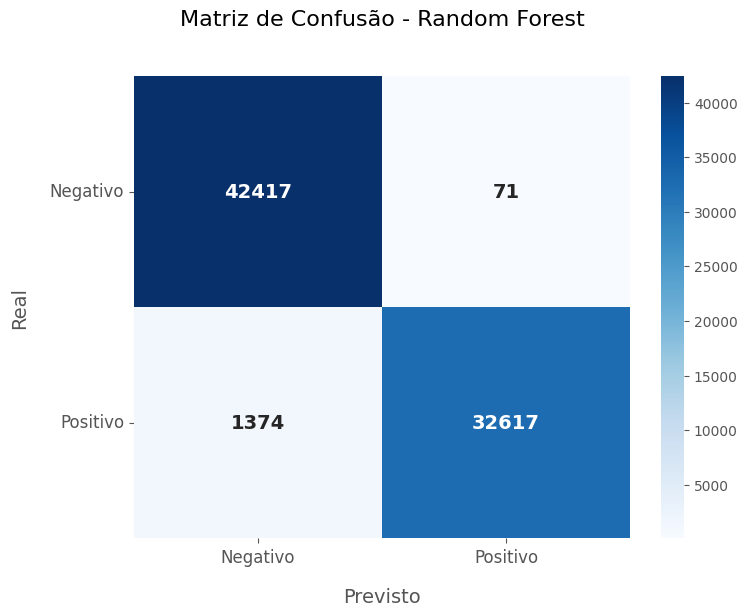

,Fold,Acurácia,Desempenho
0,1,0.9801,Ótimo
1,2,0.9799,Ótimo
2,3,0.9796,Ótimo
3,4,0.9808,Ótimo
4,5,0.9801,Ótimo


In [ ]:

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, learning_curve, cross_val_score


# --- 1. Carregar e preparar dados ---
dados_balanceados = pd.read_csv('dados_balanceados_smote_undersample.csv')
X = dados_balanceados.drop('target', axis=1)
y = dados_balanceados['target']

# Dividir dados
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# --- 2. Treinar modelo Random Forest ---
rf_model = RandomForestClassifier(
    n_estimators=150,
    max_depth=8,
    min_samples_split=10,
    min_samples_leaf=5,
    max_features='sqrt',
    random_state=42,
    n_jobs=-1,
    class_weight='balanced'
)
rf_model.fit(X_train, y_train)

# --- 3. Gerar previsões ---
y_pred = rf_model.predict(X_test)
y_proba = rf_model.predict_proba(X_test)[:, 1]
y_train_pred = rf_model.predict(X_train)
y_train_proba = rf_model.predict_proba(X_train)[:, 1]

# --- 4. Relatório de Métricas Formatado ---
def styled_metric_report(y_true, y_pred, y_proba, title):
    metrics = {
        'Acurácia': accuracy_score(y_true, y_pred),
        'Precisão': precision_score(y_true, y_pred),
        'Recall': recall_score(y_true, y_pred),
        'F1-Score': f1_score(y_true, y_pred),
        'AUC-ROC': roc_auc_score(y_true, y_proba),
        'AP Score': average_precision_score(y_true, y_proba)
    }
    df = pd.DataFrame.from_dict(metrics, orient='index', columns=['Valor'])
    df['Valor'] = df['Valor'].apply(lambda x: f"{x:.4f}")

    table_style = [
        {'selector': 'th',
         'props': [('background-color', '#4472C4'),
                  ('color', 'white'),
                  ('font-weight', 'bold'),
                  ('text-align', 'center')]},
        {'selector': 'td',
         'props': [('text-align', 'center')]},
        {'selector': '',
         'props': [('border', '1px solid #ddd'),
                   ('border-collapse', 'collapse'),
                   ('width', '50%'),
                   ('margin', '0 auto')]}
    ]

    display(HTML(f"<h3 style='color:#2E75B6; text-align:center'>{title}</h3>"))
    display(df.style.set_table_styles(table_style)
                  .set_properties(**{'background-color': '#F2F2F2',
                                    'border': '1px solid #ddd'}))

# Relatórios para treino e teste
styled_metric_report(y_train, y_train_pred, y_train_proba, "MÉTRICAS DE TREINO - RANDOM FOREST")
styled_metric_report(y_test, y_pred, y_proba, "MÉTRICAS DE TESTE - RANDOM FOREST")

# --- 5. Tabela Comparativa de Overfitting ---
metrics_train = {
    'Acurácia': accuracy_score(y_train, y_train_pred),
    'Precisão': precision_score(y_train, y_train_pred),
    'Recall': recall_score(y_train, y_train_pred),
    'F1-Score': f1_score(y_train, y_train_pred),
    'AUC-ROC': roc_auc_score(y_train, y_train_proba)
}

metrics_test = {
    'Acurácia': accuracy_score(y_test, y_pred),
    'Precisão': precision_score(y_test, y_pred),
    'Recall': recall_score(y_test, y_pred),
    'F1-Score': f1_score(y_test, y_pred),
    'AUC-ROC': roc_auc_score(y_test, y_proba)
}

comparison_df = pd.DataFrame({
    'Métrica': list(metrics_train.keys()),
    'Treino': [f"{v:.4f}" for v in metrics_train.values()],
    'Teste': [f"{v:.4f}" for v in metrics_test.values()],
    'Diferença': [f"{abs(a-b):.4f}" for a, b in zip(metrics_train.values(), metrics_test.values())]
})

def highlight_overfit(row):
    diff = float(row['Diferença'])
    color = '#FFC7CE' if diff > 0.1 else ('#FFEB9C' if diff > 0.05 else '#C6EFCE')
    return ['background-color: ' + color for _ in row]

display(HTML("<h3 style='color:#2E75B6; text-align:center'>COMPARAÇÃO TREINO-TESTE (OVERFITTING)</h3>"))
display(comparison_df.style.apply(highlight_overfit, axis=1)
                        .set_table_styles([
                            {'selector': 'th',
                             'props': [('background-color', '#4472C4'),
                                      ('color', 'white'),
                                      ('font-weight', 'bold')]},
                            {'selector': 'td',
                             'props': [('text-align', 'center')]}
                        ]))

# --- 6. Visualização da Matriz de Confusão Aprimorada ---
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred),
            annot=True, fmt='d', cmap='Blues',
            annot_kws={"size": 14, "weight": "bold"},
            xticklabels=['Negativo', 'Positivo'],
            yticklabels=['Negativo', 'Positivo'])
plt.title('Matriz de Confusão - Random Forest\n', fontsize=16, pad=20)
plt.xlabel('Previsto', fontsize=14, labelpad=15)
plt.ylabel('Real', fontsize=14, labelpad=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12, rotation=0)
plt.show()


# --- 9. Validação Cruzada em Tabela Estilizada ---
cv_scores = cross_val_score(rf_model, X_train, y_train, cv=5, scoring='accuracy')
cv_df = pd.DataFrame({
    'Fold': range(1, 6),
    'Acurácia': cv_scores,
    'Desempenho': ['Ótimo' if x > 0.9 else ('Bom' if x > 0.8 else 'Aperfeiçoar') for x in cv_scores]
})

def performance_color(val):
    color = '#C6EFCE' if val == 'Ótimo' else ('#FFEB9C' if val == 'Bom' else '#FFC7CE')
    return f'background-color: {color}'

display(HTML("<h3 style='color:#2E75B6; text-align:center'>VALIDAÇÃO CRUZADA (5 FOLDS) - RANDOM FOREST</h3>"))
display(cv_df.style.applymap(performance_color, subset=['Desempenho'])
                  .format({'Acurácia': '{:.4f}'})
                  .set_table_styles([
                      {'selector': 'th',
                       'props': [('background-color', '#4472C4'),
                                ('color', 'white'),
                                ('font-weight', 'bold')]},
                      {'selector': 'td',
                       'props': [('text-align', 'center')]}
                  ]))